In [34]:
#import packages and formatting statements

import numpy as np
from matplotlib import pyplot as plt
import astropy.io.fits as pyfits
from astropy.table import Table, join, Column
from astropy.wcs import WCS
from astropy.io import ascii
import os

plt.rc('text',usetex=False)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

In [35]:
# Compile galaxy and OSC objects
DataFile = '../Data/1.ProjectTable.csv'
Data = Table.read(DataFile, format='csv') 
galaxies, ESOmaps, MUSEres, MUSEmaps = Data["Galaxy"], Data["ESO-MPG_Hasub_wcomb_corr"], Data["MUSENatRes"], Data["MUSEmapNat"]
SNe = np.loadtxt('../Data/1.FullCatalog.csv', dtype = str, delimiter = ",",unpack=True, usecols = 0)
ras = np.loadtxt('../Data/1.FullCatalog.csv',delimiter=',', unpack = True, usecols=4)
decs = np.loadtxt('../Data/1.FullCatalog.csv',delimiter=',',unpack = True, usecols = (5))
types = np.loadtxt('../Data/1.FullCatalog.csv', dtype=str,delimiter=',', unpack=True, usecols=6)

#SNData = Table.read('../Data/1.FullCatalog.csv', format='csv') 
#SNe, ras, decs, types = SNData["Name"], np.float(SNData["RA"]), np.float(SNData["Dec"]), SNData["Type"]


In [36]:
#print(ESOmaps)
    
# types = [x.replace('',"Unclassified") for x in types]

# for i in range(len(types)):
#     print(types[i])

In [37]:
#Checks if Supernovae are in an image and reports back their x & y coords if in map

def check_in_image(SNras, SNdecs, SNnames, SNtypes, image, maptype = "MUSE"):
    
    hdulist  = pyfits.open(image)
    
    if maptype == "MUSE":
        map = hdulist["HA6562_FLUX"].data
        #emap = hdulist["HA6562_FLUX_ERR"].data     
        wcs = WCS(hdulist["HA6562_FLUX"].header, naxis=2)
        naxis = wcs._naxis #size of image
        naxis1 = hdulist["HA6562_FLUX"].header['NAXIS1']
        naxis2 = hdulist["HA6562_FLUX"].header['NAXIS2']
    else:
        map = hdulist[0].data
        #emap = "find a way to use RMS from galaxy for these"
        wcs = WCS(hdulist[0].header, naxis=2)
        #beamsize = hdulist[0].header["BEAM"]
        naxis = wcs._naxis #size of image
        naxis1 = hdulist[0].header['NAXIS1']
        naxis2 = hdulist[0].header['NAXIS2']
        
    coords_arr = np.column_stack((SNras, SNdecs)) # ras and decs now [ra,dec]
    pix_x, pix_y = wcs.wcs_world2pix(SNras,SNdecs,0)

    #use world coordinates of all SNe to see if any fall in image (our version of footprint_contains)

    is_in_x = (pix_x >= 0) & (pix_x <= naxis[0]-1) #because of 0-indexing
    is_in_y = (pix_y >= 0) & (pix_y <= naxis[1]-1)
             
    #get the name, ra, and dec of the SNe that fall in image
    #boolean array indexing (gives back array of Trues and Falses)
    #we are pulling out the SNe that are True and assigning them to own arrays
    name_in_image = np.array(SNnames)[is_in_x & is_in_y]
    type_in_image = np.array(SNtypes)[is_in_x & is_in_y]
    ra_in_image = np.array(SNras)[is_in_x & is_in_y]
    dec_in_image = np.array(SNdecs)[is_in_x & is_in_y]

    x_coord = np.array(pix_x)[is_in_x & is_in_y]
    y_coord = np.array(pix_y)[is_in_x & is_in_y]
    
    return(name_in_image, type_in_image, ra_in_image, dec_in_image, x_coord, y_coord, map, naxis1, naxis2)
    #print(name_in_image, type_in_image, ra_in_image, dec_in_image, x_coord, y_coord)


In [38]:
# Build MUSE Catalogue That has all supernovae within PHANGS-MUSE footprint

with open('../Data/2.SNeHa_MUSE_Cat.txt', 'w') as text_file:
    print('#Galaxy,Supernova,Ra,Dec,MUSE_xCoord,MUSE_yCoord,Type,MUSE_Intensity', file = text_file)

for i in range(len(galaxies)):
    if (MUSEmaps[i] != "" and os.path.isfile(MUSEmaps[i])):
    
        found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, naxis1, naxis2 = check_in_image(ras, decs, SNe, types, MUSEmaps[i])
        intensity = []
    
        for k in range(len(found_type)):

            xVal = int(round(x_coord[k]))
            yVal = int(round(y_coord[k]))
            if (yVal <= naxis2) and (xVal <= naxis1):
                intensity.append(map[yVal, xVal])

            else: 
                intensity.append(np.nan)


        with open('../Data/2.SNeHa_MUSE_Cat.txt', 'a') as text_file:
            for j in range(len(found_name)):
                print(galaxies[i], ",", found_name[j],",", found_ra[j], ",",found_dec[j],",", x_coord[j],",",y_coord[j],",", found_type[j],",", intensity[j], file = text_file)


In [39]:
# Build ESO-MPG Catalogue That has all OSC entries within PHANGS-ESO-MPG footprint

with open('../Data/2.SNeHa_ESO_Cat.txt', 'w') as text_file:
    print('#Galaxy,Supernova,Ra,Dec,ESO_xCoord,ESO_yCoord,Type,ESO_Intensity', file = text_file)

for i in range(len(galaxies)):
    if (ESOmaps[i] != "" and os.path.isfile(ESOmaps[i])):
    
        found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, naxis1, naxis2 = check_in_image(ras, decs, SNe, types, ESOmaps[i], maptype="ESO") 
        intensity = []
    
        for k in range(len(found_type)):

            xVal = int(round(x_coord[k]))
            yVal = int(round(y_coord[k]))
            if (yVal <= naxis2) and (xVal <= naxis1):
                intensity.append(map[yVal, xVal])

            else: 
                intensity.append(np.nan)


        with open('../Data/2.SNeHa_ESO_Cat.txt', 'a') as text_file:
            for j in range(len(found_name)):
                print(galaxies[i], ",", found_name[j],",", found_ra[j], ",",found_dec[j],",", x_coord[j],",",y_coord[j],",", found_type[j],",", intensity[j], file = text_file)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [40]:
# Turn files into data structure and clean

ESOdataFile = '../Data/2.SNeHa_ESO_Cat.txt'
MUSEdataFile = '../Data/2.SNeHa_MUSE_Cat.txt'
ESOTable = Table.read(ESOdataFile, format='ascii') 
MUSETable = Table.read(MUSEdataFile, format='ascii') 

database = join(ESOTable, MUSETable, keys=('Galaxy', "Supernova", "Ra", "Dec", "Type"), join_type="outer")
database = join(database, Data, keys=('Galaxy'))

database
ascii.write(database, '../Data/2.SNeHaMasterCat.csv', format='csv', fast_writer=False, overwrite=True)  


In [41]:
print(database[-1])

 Galaxy Supernova         Ra           Dec       ESO_xCoord         ESO_yCoord    Type ESO_Intensity MUSE_xCoord MUSE_yCoord MUSE_Intensity                                 ESO-MPG_Hasub_wcomb_corr                                 MUSENatRes MUSEmapNat MUSEmap150pc MUSEmap15asec
------- --------- ------------------ ------- ------------------ ----------------- ---- ------------- ----------- ----------- -------------- ---------------------------------------------------------------------------------------- ---------- ---------- ------------ -------------
NGC6744  SN2005at 287.47320833333333 -63.823 3720.6960332891404 4473.218647211148   Ic     3.1171134          --          --             -- /home/maykerchen.1/Desktop/SNeHaLargeData/HaSUB_wcomb_corr/NGC6744_Hasub_flux_corrs.fits         --         --           --            --


In [42]:
# database["Type"]

In [43]:

SN_name = [x[2:-2] for x in database["Supernova"]]

# Here we are going to filter out our undesired OSC entries:
    # One is a double counted SN named "PTSS-19clju", any LRNs or LBVs or IIns, and any candidates

flags = []
flag1 = database['Supernova'] == "PTSS-19clju" 
flag3 = database['Supernova'] == "Gaia21fml" 
flag5 = database['Supernova'] == "Gaia21cum"

flag2 = []

for i in range(len(SN_name)):
    if ("LRN" in database['Type'][i] or "LBV" in database['Type'][i] or "IIn" in database['Type'][i] or "Candidate" in database['Type'][i]):
        flag2.append(True)
    else:
        flag2.append(False)

for i in range(len(flag1)):
    if flag1[i] == True or flag2[i] == True or flag3[i] == True or flag5[i] == True:
        flags.append(True)
    else:
        flags.append(False)
        
flagsArr = np.array(flags)

c = Column(data=flags, name='Removed')
database.add_column(c)
ascii.write(database, '../Data/2.SNeHaMasterCat.csv', format='csv', fast_writer=False, overwrite = True) 

cleanData = database[flagsArr==False]

cleanData

ascii.write(cleanData, '../Data/2.SNeHaMasterCatClean.csv', format='csv', fast_writer=False, overwrite = True)  

In [44]:
cleanData

Galaxy,Supernova,Ra,Dec,ESO_xCoord,ESO_yCoord,Type,ESO_Intensity,MUSE_xCoord,MUSE_yCoord,MUSE_Intensity,ESO-MPG_Hasub_wcomb_corr,MUSENatRes,MUSEmapNat,MUSEmap150pc,MUSEmap15asec,Removed
str8,str24,float64,float64,float64,float64,str12,float64,float64,float64,float64,str89,float64,str80,str78,str80,bool
NGC0628,M74SNRJ013642400+1544163,24.17666666666667,15.73786111111111,2450.13904696686,1798.00193904955,Unclassified,0.35310355,--,--,--,/home/maykerchen.1/Desktop/SNeHaLargeData/HaSUB_wcomb_corr/NGC0628_Hasub_flux_corrs.fits,0.92,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC0628-0.92asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC0628-150pc_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/15asec/NGC0628-15asec_MAPS.fits,False
NGC0628,SN2013ej,24.200670833333334,15.758611111111112,2100.1343887503876,2112.55973726534,II,0.09700711,243.11885674825174,305.29330284886476,nan,/home/maykerchen.1/Desktop/SNeHaLargeData/HaSUB_wcomb_corr/NGC0628_Hasub_flux_corrs.fits,0.92,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC0628-0.92asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC0628-150pc_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/15asec/NGC0628-15asec_MAPS.fits,False
NGC0628,SN2002ap,24.09937916666667,15.753669444444444,3577.4210468967017,2037.470947756881,Ic,-0.17532486,--,--,--,/home/maykerchen.1/Desktop/SNeHaLargeData/HaSUB_wcomb_corr/NGC0628_Hasub_flux_corrs.fits,0.92,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC0628-0.92asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC0628-150pc_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/15asec/NGC0628-15asec_MAPS.fits,False
NGC0628,PS15blm,24.258708333333335,15.777000000000001,1253.8697326978763,2391.66186884759,Unclassified,6.3913784,--,--,--,/home/maykerchen.1/Desktop/SNeHaLargeData/HaSUB_wcomb_corr/NGC0628_Hasub_flux_corrs.fits,0.92,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC0628-0.92asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC0628-150pc_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/15asec/NGC0628-15asec_MAPS.fits,False
NGC0628,SN2003gd,24.17770833333333,15.739138888888888,2434.9505648694476,1817.369414243681,II,-0.12983386,--,--,--,/home/maykerchen.1/Desktop/SNeHaLargeData/HaSUB_wcomb_corr/NGC0628_Hasub_flux_corrs.fits,0.92,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC0628-0.92asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC0628-150pc_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/15asec/NGC0628-15asec_MAPS.fits,False
NGC1087,SN1995V,41.61154166666667,-0.49878055555555556,648.5505421656521,748.0751125890881,II,5.0002465,182.8499455412301,450.8200411854245,2663.371834437333,/home/maykerchen.1/Desktop/SNeHaLargeData/HaSUB_wcomb_corr/NGC1087_Hasub_flux_corrs.fits,0.92,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1087-0.92asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1087-150pc_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/15asec/NGC1087-15asec_MAPS.fits,False
NGC1300,LSQ14dtr,49.96679166666666,-19.478694444444443,841.190251571016,472.6653386793862,Ia,-0.06859025,--,--,--,/home/maykerchen.1/Desktop/SNeHaLargeData/HaSUB_wcomb_corr/NGC1300_Hasub_flux_corrs.fits,0.89,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1300-0.89asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1300-150pc_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/15asec/NGC1300-15asec_MAPS.fits,False
NGC1365,SN1983V,53.38192083333333,-36.148580555555554,3270.0796929140615,2906.7780980507987,II,11.953729,1027.2635595498382,309.94409754595245,5996.363596675533,/home/maykerchen.1/Desktop/SNeHaLargeData/HaSUB_wcomb_corr/NGC1365_Hasub_flux_corrs.fits,1.15,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1365-150

In [12]:
# for i in range(len(galaxies)):
#     print(data["Galaxy"][i], data["ESO-MPG_Hasub_wcomb_corr"][i])

In [45]:
# Plot ESO Galaxy Files with SNe

data = ascii.read('../Data/2.SNeHaMasterCatClean.csv')

for i in range(len(data["Galaxy"])):
    
    if (data["ESO-MPG_Hasub_wcomb_corr"][i] != "" and os.path.isfile(data["ESO-MPG_Hasub_wcomb_corr"][i])):     
    
        found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, naxis1, naxis2 = check_in_image(data['Ra'], data['Dec'], data['Supernova'], data['Type'], data["ESO-MPG_Hasub_wcomb_corr"][i], maptype = "ESO")
    
        plt.figure(figsize=(7, 7))
        logmap = np.log10(map)
        plt.imshow(logmap, origin='lower', interpolation='nearest', zorder=1)

        for k in range(len(found_name)):

            string = found_name[k]

            if (len(found_type[k])>1):
                if found_type[k][1] == "I":
                    #colorCode = 'chartreuse'
                    colorCode = 'black'
                    mkr = '*'
                elif found_type[k][1] == "b" or found_type[k][1] == "c":
                    #colorCode = 'salmon'
                    colorCode = 'darkblue'
                    mkr = '^'
                elif found_type[k][1] == "a":
                    #colorCode = 'deeppink'
                    colorCode = 'indigo'
                    mkr = 'o'
                else:
                    colorCode = 'magenta'
                    mkr = '>'
            else:
                #colorCode = 'cyan'
                colorCode = 'maroon'
                mkr='s'

            plt.plot(x_coord[k], y_coord[k], marker=mkr, ms=10, color=colorCode, zorder=10)
            plt.text(x_coord[k]-20, y_coord[k]+8, string, fontsize=12, color=colorCode)

        plt.axis('off')
        plt.title(data["Galaxy"][i], fontsize=24, fontweight='bold')
        plt.tight_layout()
        plt.savefig('../Figures/2.ESO_Galaxy_Images/' + data["Galaxy"][i] + '.png')
        if (len(found_name) > 0):
            plt.savefig('../Figures/2.ESO_SNe_Galaxy_Images/' + data["Galaxy"][i] + '.png')
        plt.close()

<ipython-input-45-b6b9cd9477f5>:12: RuntimeWarning: invalid value encountered in log10
  logmap = np.log10(map)
<ipython-input-45-b6b9cd9477f5>:12: RuntimeWarning: divide by zero encountered in log10
  logmap = np.log10(map)


In [47]:
for i in range(len(data)):
    print(data["Galaxy"][i])

NGC0628
NGC0628
NGC0628
NGC0628
NGC0628
NGC1087
NGC1300
NGC1365
NGC1365
NGC1365
NGC1365
NGC1433
NGC1512
NGC1566
NGC1566
NGC1566
NGC1672
NGC1672
NGC2997
NGC2997
NGC3351
NGC3627
NGC3627
NGC3627
NGC3627
NGC4254
NGC4254
NGC4254
NGC4254
NGC4293
NGC4298
NGC4303
NGC4303
NGC4303
NGC4303
NGC4303
NGC4303
NGC4303
NGC4303
NGC4321
NGC4321
NGC4321
NGC4321
NGC4321
NGC4321
NGC4321
NGC4496A
NGC4496A
NGC4540
NGC4569
NGC4569
NGC4571
NGC6744
NGC6744


In [46]:
# Plot MUSE Galaxy Files with SNe
inMuse = []

for i in range(len(data["Galaxy"])):
    
    if (data["MUSEmapNat"][i] != "" and os.path.isfile(data["MUSEmapNat"][i])):     
    
        found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, naxis1, naxis2 = check_in_image(data['Ra'], data['Dec'], data['Supernova'], data['Type'], data["MUSEmapNat"][i])
    
        plt.figure(figsize=(7, 7))
        logmap = np.log10(map)
        plt.imshow(logmap, origin='lower', interpolation='nearest', zorder=1)

        for k in range(len(found_name)):
            inMuse.append(found_name[k])
            string = found_name[k]

            if (len(found_type[k])>1):
                if found_type[k][1] == "I":
                    #colorCode = 'chartreuse'
                    colorCode = 'black'
                    mkr = '*'
                elif found_type[k][1] == "b" or found_type[k][1] == "c":
                    #colorCode = 'salmon'
                    colorCode = 'darkblue'
                    mkr = '^'
                elif found_type[k][1] == "a":
                    #colorCode = 'deeppink'
                    colorCode = 'indigo'
                    mkr = 'o'
                else:
                    colorCode = 'magenta'
                    mkr = '>'
            else:
                #colorCode = 'cyan'
                colorCode = 'maroon'
                mkr='s'

            plt.plot(x_coord[k], y_coord[k], marker=mkr, ms=10, color=colorCode, zorder=10)
            plt.text(x_coord[k]-20, y_coord[k]+8, string, fontsize=12, color=colorCode)

        plt.axis('off')
        plt.title(data["Galaxy"][i], fontsize=24, fontweight='bold')
        plt.tight_layout()
        plt.savefig('../Figures/2.MUSE_Galaxy_Images/' + data["Galaxy"][i] + '.png')
        if (len(found_name) > 0):
            plt.savefig('../Figures/2.MUSE_SNe_Galaxy_Images/' + data["Galaxy"][i] + '.png')
        plt.close()

<ipython-input-46-baab7ee40c08>:11: RuntimeWarning: divide by zero encountered in log10
  logmap = np.log10(map)


In [22]:
#Organize the MUSE sample (remove repeat entries and remove those outside of maps)
muselist = list( dict.fromkeys(inMuse) )

inMuseSample = []

for i in range(len(database["Supernova"])):
    #remove by hand the SNe that are just outside of MUSE maps
    if database["Supernova"][i] == "SN2013ej" or database["Supernova"][i] == "SN1979C":
        inMuseSample.append("False")
    elif database["Supernova"][i] in muselist:
        inMuseSample.append("True")
    else: 
        inMuseSample.append("False")
        
# for i in range(len(database)):
#     print(database["Supernova"][i], inMuseSample[i])
    

In [23]:
# Make a table of organized MUSE sample
museSample = Table({"Supernova": database["Supernova"],
                    "InMuseSample" : inMuseSample})

museSample.write("../Data/2.museSample.csv", format = "csv")

In [24]:
data[0:2]

Galaxy,Supernova,Ra,Dec,ESO_xCoord,ESO_yCoord,Type,ESO_Intensity,MUSE_xCoord,MUSE_yCoord,MUSE_Intensity,ESO-MPG_Hasub_wcomb_corr,MUSENatRes,MUSEmapNat,MUSEmap150pc,MUSEmap15asec,Removed
str8,str24,float64,float64,float64,float64,str12,float64,float64,float64,float64,str89,float64,str80,str78,str80,str5
NGC0628,M74SNRJ013642400+1544163,24.17666666666667,15.73786111111111,2450.13904696686,1798.00193904955,Unclassified,0.35310355,--,--,--,/home/maykerchen.1/Desktop/SNeHaLargeData/HaSUB_wcomb_corr/NGC0628_Hasub_flux_corrs.fits,0.92,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC0628-0.92asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC0628-150pc_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/15asec/NGC0628-15asec_MAPS.fits,False
NGC0628,SN2013ej,24.200670833333334,15.758611111111112,2100.1343887503876,2112.55973726534,II,0.09700711,243.11885674825174,305.29330284886476,nan,/home/maykerchen.1/Desktop/SNeHaLargeData/HaSUB_wcomb_corr/NGC0628_Hasub_flux_corrs.fits,0.92,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC0628-0.92asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC0628-150pc_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/15asec/NGC0628-15asec_MAPS.fits,False


In [27]:
#Group data by galaxy
gal_groups = data.group_by('Galaxy')
gals = gal_groups.groups.keys
indices = gal_groups.groups.indices
indices = indices.tolist()
indices.append(0)

# print(gals)
# print(indices)
# print(gal_groups["SN_name"][4])

images, name, types, ras, decs = [],[],[],[],[]
# errfiles, dists = [],[]
for i in range(len(indices)-2):
    SNnames, SNtypes, SNras, SNdecs = [],[],[],[]
    images.append(gal_groups["MUSEmapNat"][indices[i]])
    SNnames.append(gal_groups["Supernova"][indices[i]])
    SNtypes.append(gal_groups["Type"][indices[i]])
    SNras.append(gal_groups["Ra"][indices[i]])
    SNdecs.append(gal_groups["Dec"][indices[i]])
    j = 1
    while(indices[i] + j < indices[i+1]):
        SNnames.append(gal_groups["Supernova"][indices[i]+j])
        SNtypes.append(gal_groups["Type"][indices[i]+j])
        SNras.append(gal_groups["Ra"][indices[i]+j])
        SNdecs.append(gal_groups["Dec"][indices[i]+j])
        j += 1
    name.append(SNnames)
    types.append(SNtypes)
    ras.append(SNras)
    decs.append(SNdecs)    
  

In [33]:
# set up plots.
import matplotlib.pyplot as plt
SNgals, plots, wcss, legendLabels = [],[],[],[]
# beamsizes, plotAspect, ppb, corner, scalebars = [],[],[],[],[],[],[],[],[]


for i in range(len(gals)):
        
    if os.path.isfile(images[i]):
        SNgals.append(gals[i][0])
        img = images[i]
        hdu = pyfits.open(img)
        map = hdu[0].data
        plots.append(map)
        w = WCS(hdu[0].header, naxis=2)
        wcss.append(w)
        
        legendlabel = []
        if len(name[i]) > 1:
            for k in range(len(name[i])):
                if types[i][k] == 'Unclassified':
                    typelabel = name[i][k] + ' '  + types[i][k]
                else:
                    typelabel = name[i][k] + ' Type '  + types[i][k]
                legendlabel.append(typelabel)
        else:
            if types[i][0] == 'Unclassified':
                legendlabel.append(name[i][0] + ' '  + types[i][0]) 
            else:        
                legendlabel.append(name[i][0] + ' Type '  + types[i][0])
        legendLabels.append(legendlabel)
        
print(legendLabels)
print(SNgals)
print(len(plots))

[['M74SNRJ013642400+1544163 Unclassified', 'SN2013ej Type II', 'SN2002ap Type Ic', 'PS15blm Unclassified', 'SN2003gd Type II'], ['SN1995V Type II'], ['LSQ14dtr Type Ia'], ['SN1983V Type II', 'SN2001du Type IIP', 'SN2012fr Type Ia', 'SN1957C Unclassified'], ['SN1985P Type II'], ['SN2010iv Type Ia'], ['SN2022aau Type II', 'SN2017gax Type Ib/c'], ['SN2012aw Type IIP'], ['SN1989B Type Ia', 'SN2009hd Type II', 'SN1973R Type II', 'SN2016cok Type IIP'], ['SN2014L Type Ic', 'SN1967H Type II', 'SN1972Q Type II', 'SN1986I Type II'], ['SN1926A Type II', 'SN1961I Type II', 'SN1964F Type II', 'SN2006ov Type II', 'SN2008in Type II', 'SN2014dt Type Ia-pec', 'SN2020jfo Type II', 'SN1999gn Type II'], ['SN1979C Type IIL', 'SN1959E Type I', 'SN1901B Type I', 'SN1914A Unclassified', 'SN2019ehk Type Ib', 'SN2020oi Type Ic', 'SN2006X Type Ia']]
['NGC0628', 'NGC1087', 'NGC1300', 'NGC1365', 'NGC1433', 'NGC1512', 'NGC1672', 'NGC3351', 'NGC3627', 'NGC4254', 'NGC4303', 'NGC4321']
12


<ipython-input-31-aff788baf805>:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  current_cmap.set_bad("black")


TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable log10 method

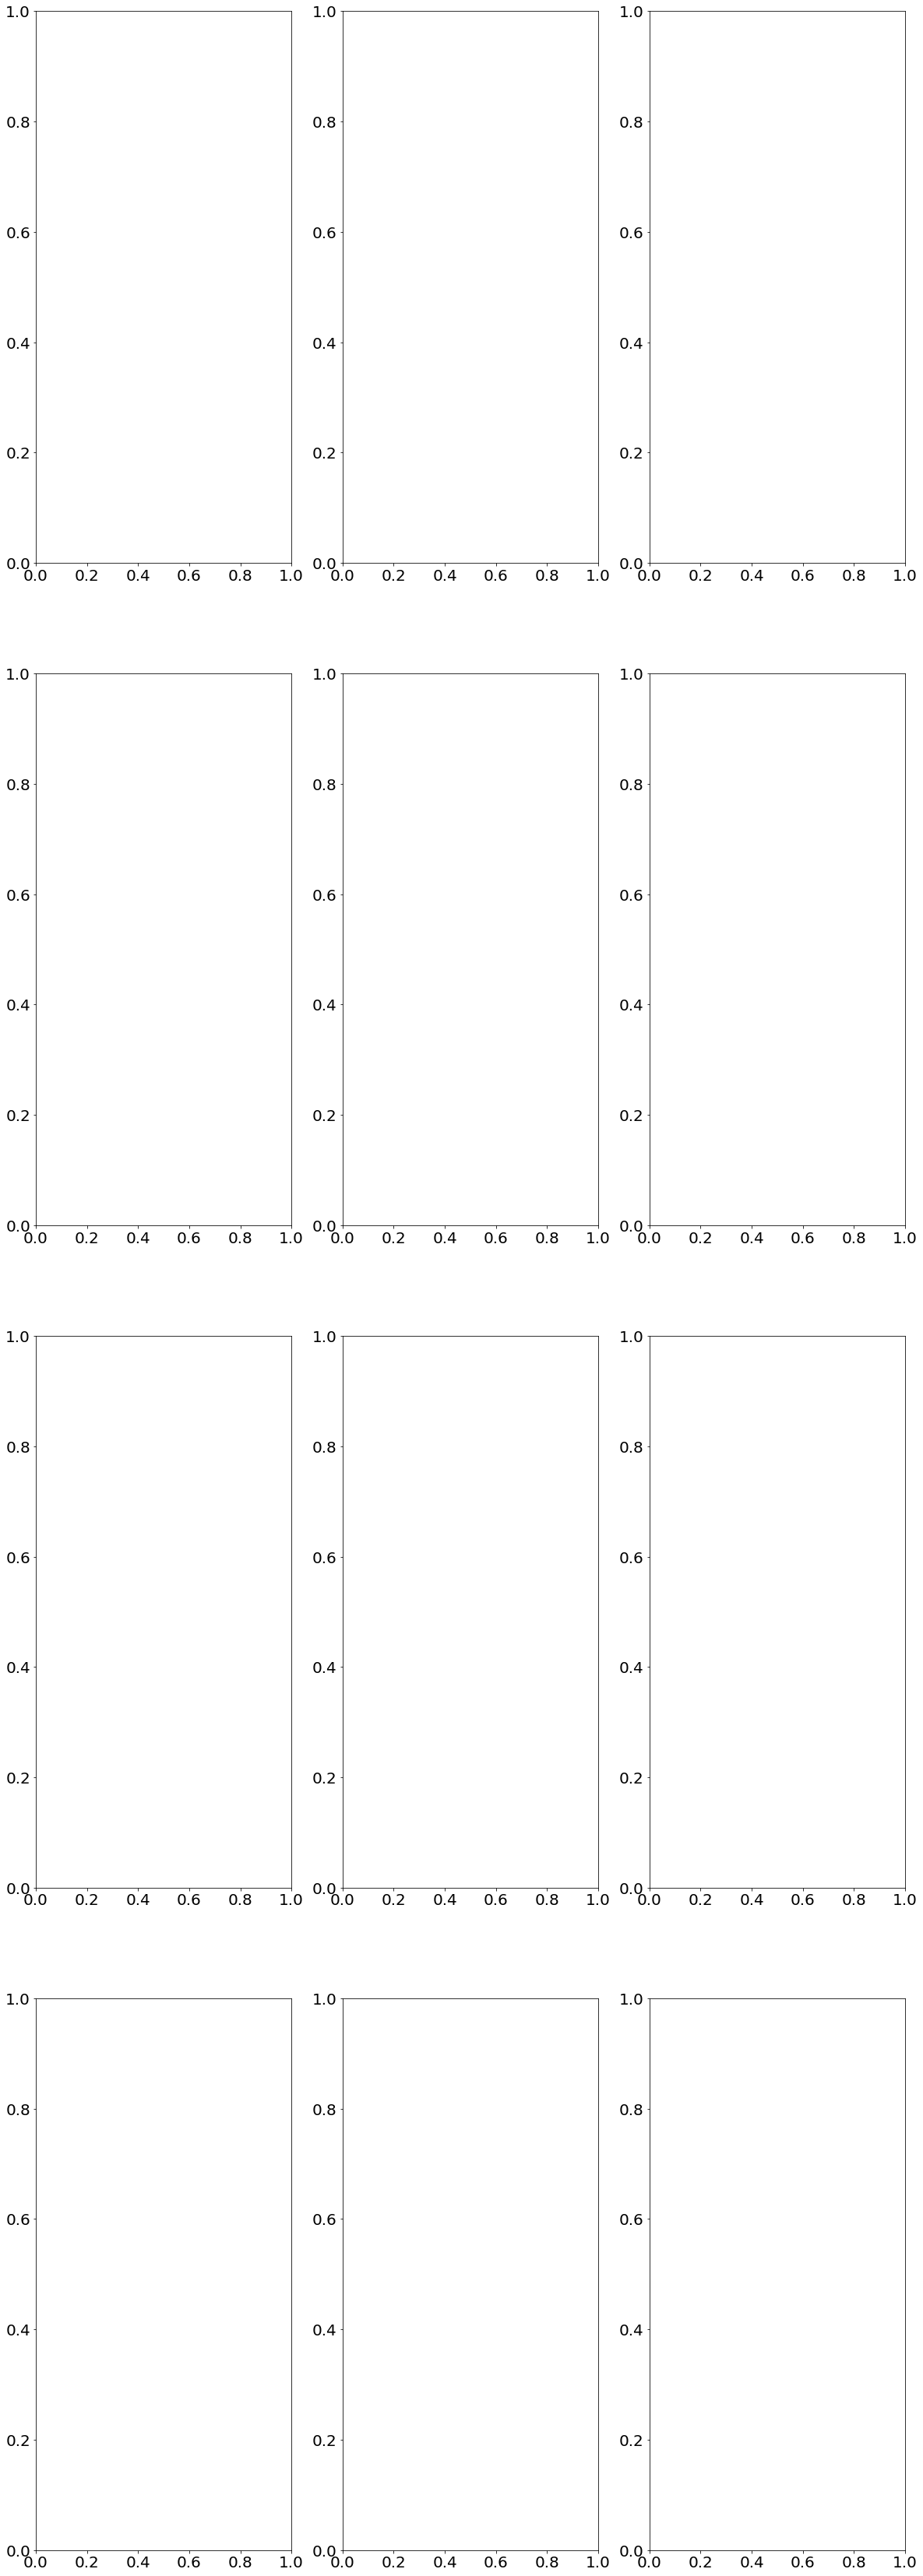

In [31]:
from matplotlib.patches import Circle


markerShapes = ["o", "s", "*", "D", "X", "H", "v"]
markerSizes  = [120,120,200,120,120,120,120]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

import math
i,j,m=0,0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))
for plot in plots:
    xArr, yArr = wcss[m].wcs_world2pix(ras[m],decs[m],0)
    logplot = np.log10(plot)
    axs[i][j].imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest", vmin = -0.5, vmax = 2.0)
    axs[i][j].set_title(gals[m].upper(), fontsize=20)
#     axs[i][j].contour(sigma[m], [3], colors = ["white"], linestyles = ("-"))
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    axs[i][j].add_patch(draw_circle)
    for n in range(len(decs[m])):
        axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
        axs[i][j].scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], edgecolor="black", label = legendLabels[m][n])
    axs[i][j].legend(loc="best", fontsize=14, handletextpad=0.007)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m +=1
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()
fig.savefig("../Figures/AllSNeInGalaxies.png", dpi=300)
   

print()